> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

# Scenes and AOIs

We have seen how to use [RasterSources](reading_raster_data.ipynb) and [LabelSources](reading_labels.ipynb#LabelSource) in other tutorials.

---

## Example

In [1]:
image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif'
label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson'

In [2]:
from rastervision.core.data import RasterioSource

raster_source = RasterioSource(image_uri, allow_streaming=True)

In [3]:
from rastervision.core.data import (
    ClassConfig, ClassInferenceTransformer, GeoJSONVectorSource,
    RasterizedSource, Scene)

class_config = ClassConfig(
    names=['background', 'building'], 
    colors=['lightgray', 'darkred'],
    null_class='background')

class_inf_tf = ClassInferenceTransformer(
    default_class_id=class_config.get_class_id('building'))

vector_source = GeoJSONVectorSource(
    label_uri,
    ignore_crs_field=True,
    crs_transformer=raster_source.crs_transformer,
    vector_transformers=[class_inf_tf])

label_raster_source = RasterizedSource(
    vector_source=vector_source,
    background_class_id=class_config.null_class_id,
    bbox=raster_source.bbox)

2022-10-20 08:59:30:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson.


Define some AOI using polygons:

In [4]:
from shapely.geometry import Polygon

aoi_polygons = [
    Polygon.from_bounds(xmin=0, ymin=0, xmax=500, ymax=500),
    Polygon.from_bounds(xmin=600, ymin=600, xmax=1024, ymax=1024),
]

Visualize the AOI:

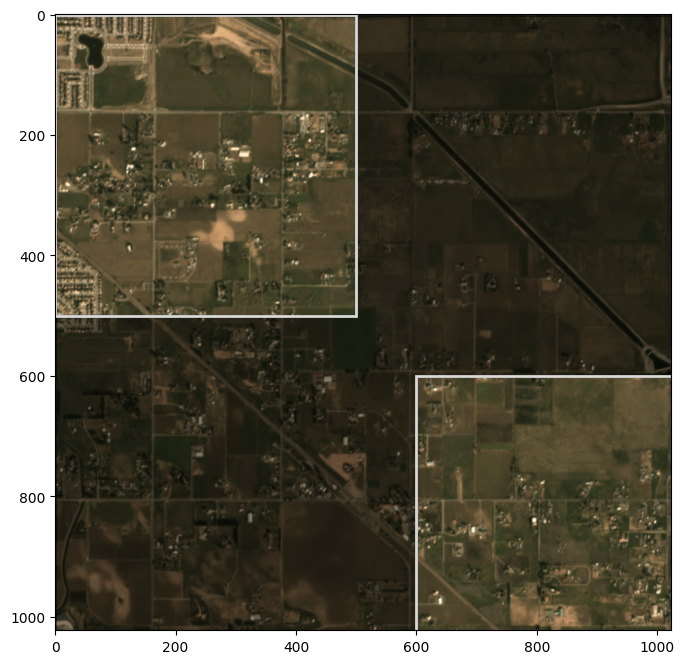

In [5]:
import numpy as np
from shapely.ops import unary_union
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches

img = raster_source[:, :]

H, W = img.shape[:2]
extent = Polygon.from_bounds(0, 0, W, H)
bg = extent.difference(unary_union(aoi_polygons))
bg = bg if bg.geom_type == 'MultiPolygon' else [bg]

fig, ax = plt.subplots(1, 1, squeeze=True, figsize=(8, 8))
ax.imshow(img)

for p in bg:
    p = mpatches.Polygon(np.array(p.exterior), color='k', linewidth=2, alpha=0.5)
    ax.add_patch(p)

for aoi in aoi_polygons:
    p = mpatches.Polygon(
        np.array(aoi.exterior), color='#d9d9d9', linewidth=2, fill=False)
    ax.add_patch(p)

plt.show()

In [6]:
from rastervision.core.data import Scene

scene = Scene(
    id='my_scene',
    raster_source=raster_source,
    label_source=label_raster_source,
    aoi_polygons=aoi_polygons)

We can now index the scene like so:

In [7]:
x, y = scene[100:200, 100:200]

x.shape, y.shape

((100, 100, 3), (100, 100, 1))

Note that the `Scene` itself does not prevent you from reading windows outside the AOI. 

In [8]:
from rastervision.core.box import Box

window_inside_aoi = Box(ymin=100, xmin=100, ymax=200, xmax=200)
window_not_inside_aoi = Box(ymin=500, xmin=500, ymax=600, xmax=600)

print(window_inside_aoi, Box.within_aoi(window_inside_aoi, aoi_polygons))
print(window_not_inside_aoi, Box.within_aoi(window_not_inside_aoi, aoi_polygons))

Box(ymin=100, xmin=100, ymax=200, xmax=200) True
Box(ymin=500, xmin=500, ymax=600, xmax=600) False


## Easier initialization

If you found the above steps to be tedious, there is an alternative, simpler way of creating a scene:

In [9]:
from rastervision.core.data.utils import make_ss_scene

scene = make_ss_scene(
    class_config=class_config,
    image_uri=image_uri,
    label_vector_uri=label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    image_raster_source_kw=dict(allow_streaming=True))

2022-10-20 08:59:38:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson.
